In [1]:
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
iris = sklearn.datasets.load_iris()

X = np.array(iris.data)[:100, :2]
y = np.array(iris.target)[:100]
y[y == 0] = -1

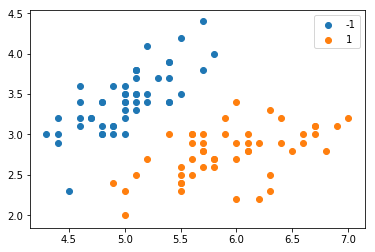

In [3]:
plt.scatter(X[:50,0],X[:50,1], label='-1')
plt.scatter(X[50:,0],X[50:,1], label='1')
plt.legend()

In [4]:
X, y = sklearn.utils.shuffle(X, y)
X_train, y_train = X[:75], y[:75]
X_test, y_test = X[75:], y[75:]

In [5]:
class SVM:
    def __init__(self, num_iter, kernel=None, epsilon=0.001):
        self.num_iter = num_iter
        self.epsilon = epsilon
        self.kernel_fn = kernel

    def _init_param(self, X, y):
        self.X = X
        self.y = y
        self.num_sample, self.num_feature = X.shape

        self.b = 0
        self.alpha = np.zeros(self.num_sample)
        self.E = np.array([self.estimate_diff(i) for i in range(self.num_sample)])
        self.C = 1.0

    def kernel(self, a, b):
        if self.kernel_fn is None:
            return np.dot(a, b)
        else:
            return self.kernel_fn(a, b)

    def estimate(self, i):
        ret = self.b
        for j in range(self.num_sample):
            ret += self.alpha[j] * self.y[j] * self.kernel(X[j], X[i])
        return ret

    def estimate_diff(self, i):
        return self.estimate(i) - self.y[i]

    def update(self):
        for i in range(len(self.E)):
            self.E[i] = self.estimate_diff(i)

    def KKT(self, i):
        ygx = self.y[i] * self.estimate(i)
        if abs(self.alpha[i]) < self.epsilon:
            return ygx >= 1
        elif abs(self.alpha[i] - self.C) < self.epsilon:
            return ygx <= 1
        else:
            return abs(ygx - 1) < self.epsilon

    def step(self, i1, i2):
        X1, X2 = self.X[i1], self.X[i2]
        y1, y2 = self.y[i1], self.y[i2]
        alpha1, alpha2 = self.alpha[i1], self.alpha[i2]
        E1, E2 = self.E[i1], self.E[i2]

        # Find the boundary of alpha[i2]
        if y1 != y2:
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha2 + alpha1 - self.C)
            H = min(self.C, alpha2 + alpha1)
        if L == H:
            return False

        eta = self.kernel(X1, X1) + self.kernel(X2, X2) - 2 * self.kernel(X1, X2)
        if eta == 0:
            return False

        alpha2_new_unc = alpha2 + y2 * (E1 - E2) / eta
        if alpha2_new_unc > H:
            alpha2_new = H
        elif alpha2_new_unc < L:
            alpha2_new = L
        else:
            alpha2_new = alpha2_new_unc
        alpha1_new = alpha1 + y1 * y2 * (alpha2 - alpha2_new)

        b1_new = -E1 - y1 * self.kernel(X1, X1) * (alpha1_new - alpha1) - y2 * self.kernel(X2, X1) * (
                alpha2_new - alpha2) + self.b
        b2_new = -E2 - y1 * self.kernel(X1, X2) * (alpha1_new - alpha1) - y2 * self.kernel(X2, X2) * (
                alpha2_new - alpha2) + self.b
        if 0 < alpha1_new < self.C:
            b_new = b1_new
        elif 0 < alpha2_new < self.C:
            b_new = b2_new
        else:
            b_new = (b1_new + b2_new) / 2
            
        self.alpha[i1] = alpha1_new
        self.alpha[i2] = alpha2_new
        self.b = b_new
        self.update()

        return True

    def fit(self, X, y):
        self._init_param(X, y)

        iter = 0
        while iter < self.num_iter:
            index = list(range(self.num_sample))
            i1_candidate = [i for i in index if 0 < self.alpha[i] < self.C]
            i1_candidate = i1_candidate + list(set(index) - set(i1_candidate))

            i1, i2 = 0, 0
            for i1 in i1_candidate:
                if self.KKT(i1):
                    continue
                i2 = int(random.randint(0, self.num_sample - 1))
                iter += 1
                if self.step(i1, i2):
                    break

    def predict(self, data):
        ret = self.b
        for i in range(self.num_sample):
            ret += self.alpha[i] * self.y[i] * self.kernel(data, self.X[i])
        return np.where(ret > 0, 1, -1)


In [6]:
model = SVM(200)

In [7]:
model.fit(X_train, y_train)

In [8]:
(np.array([model.predict(i) for i in X_test]) == y_test).sum() / y_test.shape[0]

1.0